## FX data prediction using Prophet

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import getcwd
import warnings
warnings.filterwarnings("ignore")
from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.all import ExponentialSmoothing
from sktime.forecasting.all import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display_html
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from util_prophet import *

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [175]:
def model_evaluate(y_test, y_pred,y_train, var):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = MeanAbsolutePercentageError(symmetric=False)
    mape = mape(y_test, y_pred)
    smape = MeanAbsolutePercentageError()
    smape_val = smape(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train = y_train)
    return pd.DataFrame([[mae,mse,rmse,mape,smape_val,mase]],columns = ['MAE','MSE','RMSE','MAPE','sMAPE','MASE'],index= ['Test vs Pred - ' + var])

In [195]:
def build_prophet(data, curr, reg1):
    df_prophet = data.reset_index().copy()
    df_prophet['y'] = df_prophet[curr]
    df_prophet['ds'] = df_prophet['index']
    y_train, y_test = temporal_train_test_split(df_prophet)
    
    model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10)
    model.add_regressor(reg1)
    model.fit(y_train)
    
    future_data = model.make_future_dataframe(periods=len(y_test), freq='d')
    forecast_data = model.predict(y_test)
    
    p = model.plot(forecast_data)
    plt.scatter(pd.to_datetime(y_test['ds']),pd.to_numeric(y_test['y']), color='r', marker='.')
    plt.legend()
    plt.show()
    
    y_pred_prophet = forecast_data[-len(y_test):]['yhat']
    
    forecast_data['Change in yhat'] = forecast_data['yhat'].diff()
    forecast_data['yhat direction'] = np.where(forecast_data['Change in yhat'] > 0, 1, 0)
    y_test = y_test.merge(forecast_data[['ds','yhat direction', 'yhat']], how = 'left', on = 'ds')

    return  [model_evaluate(y_pred_prophet,y_test['y'],y_train['y'],curr), 
            classification_report(y_test['Direction'], y_test['yhat direction']),
            confusion_matrix(y_test['Direction'], y_test['yhat direction'])]

In [177]:
import quandl
#import wrds
import functools
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key="ZNndJ3C7Y1SBCtdKn-MP",
                          start_date='2000-01-01', end_date='2019-12-31')
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl already defined


In [178]:
# Interest Rate Data
rates = fetch_quandl(tuple(['YC/USA5Y','YC/FRA5Y','YC/NZL5Y','YC/GBR5Y','YC/CAN5Y','YC/JPN5Y'])).interpolate().dropna()
rates

# Read Data from CSV
forex_data = pd.read_csv('../data/Foreign_Exchange_Rates.csv', na_values='ND')

#Column Cleanup
extracted_columns = ['Time Serie', 'EURO AREA - EURO/US$', 'NEW ZEALAND - NEW ZELAND DOLLAR/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'CANADA - CANADIAN DOLLAR/US$', 'JAPAN - YEN/US$']
named_columns = ['date', 'EURUSD', 'NZDUSD', 'GBPUSD', 'CADUSD', 'JPYUSD']
forex_data = forex_data[extracted_columns]
forex_data.columns = named_columns

# Set Date as Index
forex_data = forex_data.set_index('date')
forex_data.index = pd.to_datetime(forex_data.index) 

#Keep Only Business Days
forex_data = forex_data.interpolate().loc[rates.index.min():]

#Display Sample
display(forex_data)

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
date,,,,,
2004-08-20,0.81140,1.4859,0.54910,1.2980,109.320
2004-08-23,0.81990,1.4981,0.55120,1.3065,109.470
2004-08-24,0.82650,1.5328,0.55760,1.3048,109.630
2004-08-25,0.82710,1.5354,0.55660,1.3047,110.380
2004-08-26,0.82750,1.5411,0.55740,1.3123,109.730
...,...,...,...,...,...
2019-12-25,0.90145,1.5030,0.77035,1.3142,109.525
2019-12-26,0.90070,1.5002,0.76880,1.3124,109.670
2019-12-27,0.89490,1.4919,0.76390,1.3073,109.470


,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
# of Non-Missing Observations,"4,008.00","4,008.00","4,008.00","4,008.00","4,008.00"
Mean,0.79,1.39,0.64,1.16,103.63
Median,0.78,1.40,0.63,1.15,107.18
Minimum Value,0.62,1.13,0.47,0.92,75.72
Maximum Value,0.96,2.03,0.83,1.46,125.58


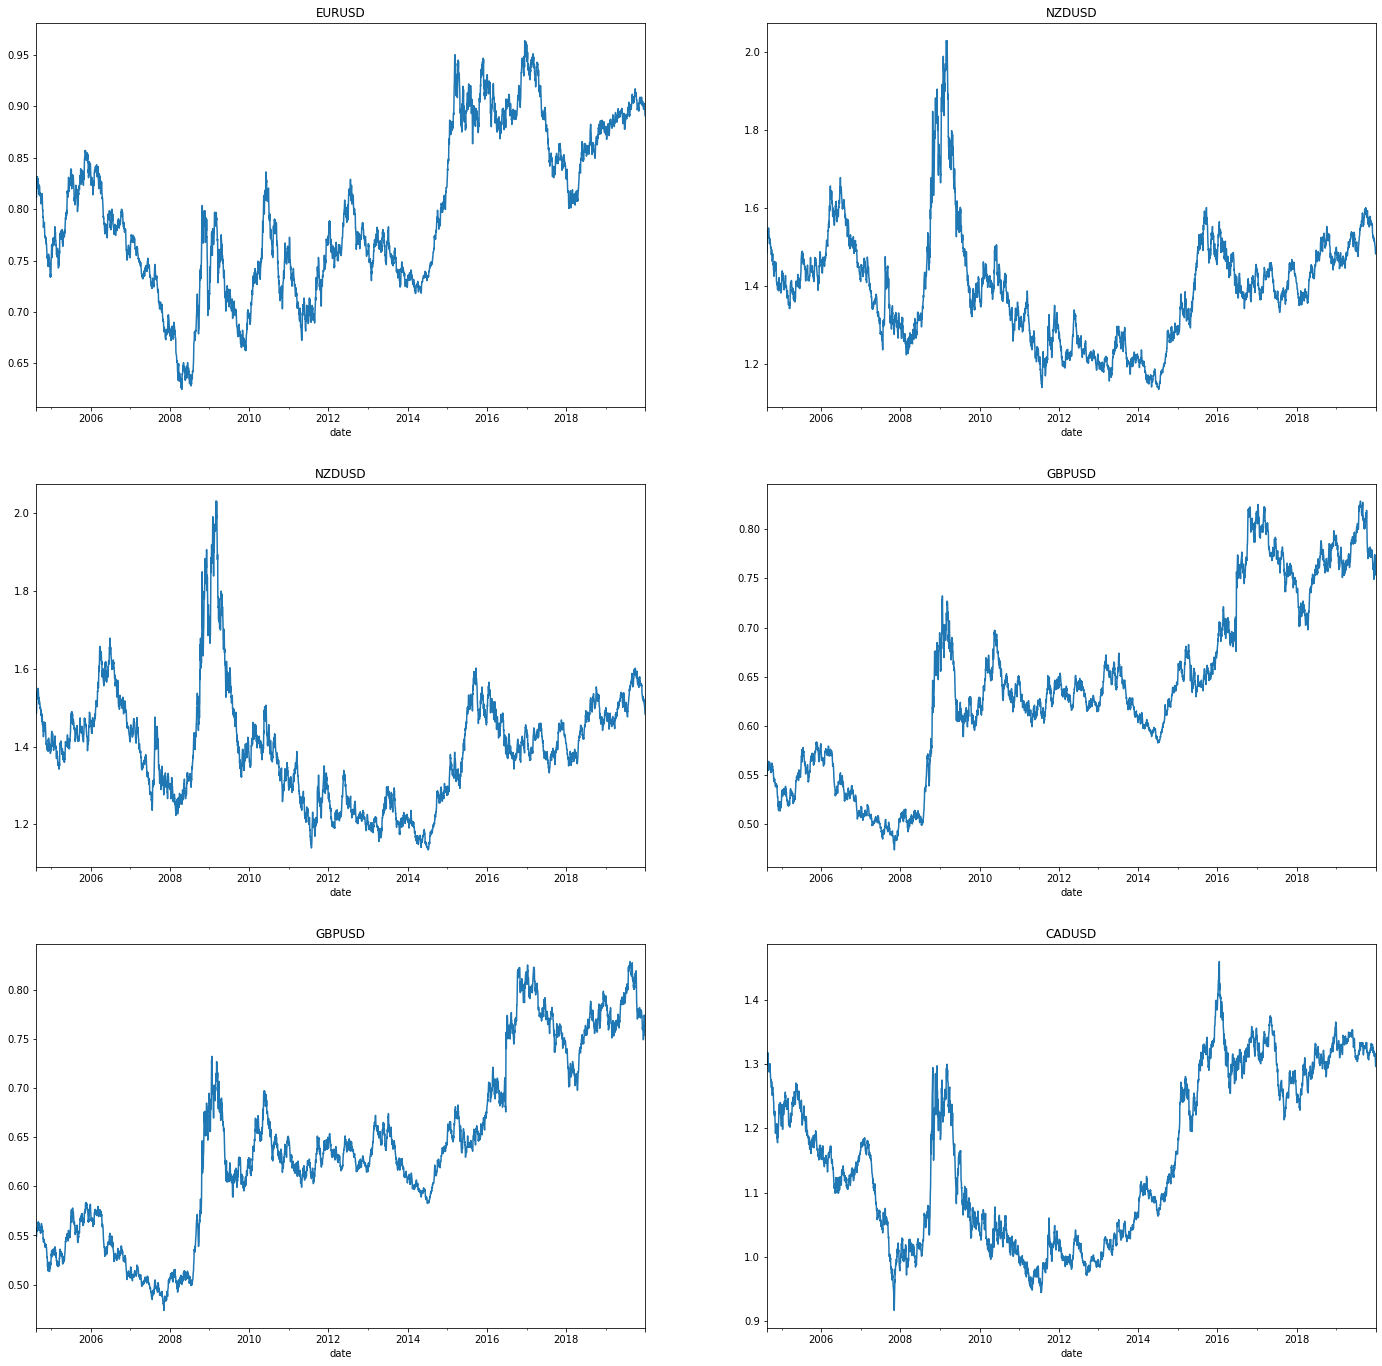

In [179]:
pa_summary = forex_data.describe()
pa_summary = pa_summary.loc[['count', 'mean', '50%', 'min', 'max']]
pa_summary.index = ['# of Non-Missing Observations', 'Mean', 'Median', 'Minimum Value', 'Maximum Value']

# Data Summary Table
display(pa_summary.style.format('{:,.2f}'))

# Data Plots
rows = 3
cols = 2
fig, ax = plt.subplots(rows, cols, figsize = (24,24))

for i in range(rows):
    for j in range(cols):
        forex_data.iloc[:,(i+j)].plot(ax = ax[i][j])
        ax[i][j].set_title(forex_data.iloc[:,(i+j)].name)

In [180]:
rates = fetch_quandl(tuple(['YC/USA5Y','YC/FRA5Y','YC/NZL5Y','YC/GBR5Y','YC/CAN5Y','YC/JPN5Y'])).interpolate().dropna()
rates

,YC/USA5Y - Rate,YC/FRA5Y - Rate,YC/NZL5Y - Rate,YC/GBR5Y - Yield,YC/CAN5Y - Rate,YC/JPN5Y - Yield
Date,,,,,,
2004-08-20,3.42,0.594002,6.140000,4.9500,3.760000,0.732
2004-08-23,3.46,0.594020,6.140000,5.0300,3.800000,0.762
2004-08-24,3.46,0.594037,6.210000,5.0300,3.850000,0.759
2004-08-25,3.46,0.594055,6.210000,4.9800,3.830000,0.789
2004-08-26,3.42,0.594072,6.190000,4.9600,3.810000,0.773
...,...,...,...,...,...,...
2019-12-25,1.72,-0.354667,1.346667,0.5510,1.633333,-0.111
2019-12-26,1.72,-0.358333,1.343333,0.5514,1.626667,-0.120
2019-12-27,1.68,-0.362000,1.340000,0.5518,1.620000,-0.120


In [181]:
data = forex_data.merge(rates,left_index=True, right_index=True)
data.head()

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD,YC/USA5Y - Rate,YC/FRA5Y - Rate,YC/NZL5Y - Rate,YC/GBR5Y - Yield,YC/CAN5Y - Rate,YC/JPN5Y - Yield
2004-08-20,0.8114,1.4859,0.5491,1.2980,109.32,3.42,0.594002,6.14,4.95,3.76,0.732
2004-08-23,0.8199,1.4981,0.5512,1.3065,109.47,3.46,0.594020,6.14,5.03,3.80,0.762
2004-08-24,0.8265,1.5328,0.5576,1.3048,109.63,3.46,0.594037,6.21,5.03,3.85,0.759
2004-08-25,0.8271,1.5354,0.5566,1.3047,110.38,3.46,0.594055,6.21,4.98,3.83,0.789
2004-08-26,0.8275,1.5411,0.5574,1.3123,109.73,3.42,0.594072,6.19,4.96,3.81,0.773


### GBP

In [197]:
data_gbp = data[['GBPUSD', 'YC/GBR5Y - Yield', 'YC/USA5Y - Rate']]
data_gbp[['YC/GBR5Y - Yield', 'YC/USA5Y - Rate']] = data_gbp[['YC/GBR5Y - Yield', 'YC/USA5Y - Rate']].shift()
data_gbp['Change in Spot'] = data_gbp['GBPUSD'].diff()
data_gbp['Direction'] = np.where(data_gbp['Change in Spot'] > 0, 1, 0)
data_gbp['gbp_spread'] = (data['YC/GBR5Y - Yield'])/(data['YC/USA5Y - Rate'])
data_gbp = data_gbp.dropna()

#### Parameter Tuning with Grid search

In [167]:
import itertools

In [169]:
df_prophet = data_gbp.reset_index().copy()
df_prophet['y'] = df_prophet['GBPUSD']
df_prophet['ds'] = df_prophet['index']
#y_train, y_test = temporal_train_test_split(df_prophet)

In [170]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(model, initial='730 days', period='1825 days', horizon = '365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-01-02 00:00:00 and 2018-12-31 00:00:00



    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.080374
1                     0.001                     0.10  0.078031
2                     0.001                     1.00  0.080262
3                     0.001                    10.00  0.080377
4                     0.010                     0.01  0.064685
5                     0.010                     0.10  0.068768
6                     0.010                     1.00  0.066611
7                     0.010                    10.00  0.068595
8                     0.100                     0.01  0.090553
9                     0.100                     0.10  0.090634
10                    0.100                     1.00  0.090938
11                    0.100                    10.00  0.091495
12                    0.500                     0.01  0.085149
13                    0.500                     0.10  0.086509
14                    0.500                     1.00  

We get changepoint_prior_scale = 0.01 and seasonality_prior_scale = 10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


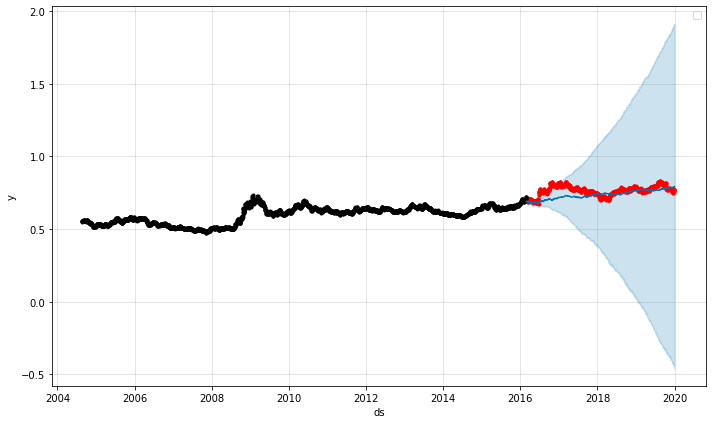

In [201]:
gbp_summary_data, gbp_classification, gbp_confusion = build_prophet(data_gbp,'GBPUSD','gbp_spread')

### CAD

In [206]:
data_cad = data[['CADUSD', 'YC/CAN5Y - Rate', 'YC/USA5Y - Rate']]
data_cad[['YC/CAN5Y - Rate', 'YC/USA5Y - Rate']] = data_cad[['YC/CAN5Y - Rate', 'YC/USA5Y - Rate']].shift()
data_cad['Change in Spot'] = data_cad['CADUSD'].diff()
data_cad['Direction'] = np.where(data_cad['Change in Spot'] > 0, 1, 0)
data_cad['cad_spread'] = (data['YC/CAN5Y - Rate'])/(data['YC/USA5Y - Rate'])
data_cad = data_cad.dropna()
X_cad, y_cad = data_cad[['YC/CAN5Y - Rate', 'YC/USA5Y - Rate']], data_cad['Direction']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


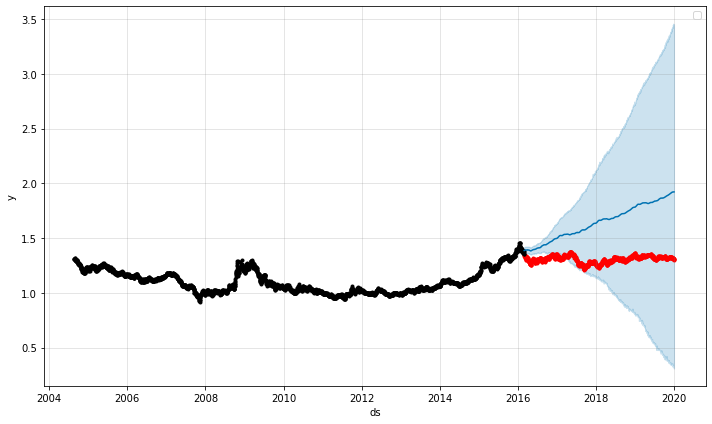

In [207]:
cad_summary_data, cad_classification, cad_confusion = build_prophet(data_cad,'CADUSD','cad_spread')

### EUR

In [210]:
data_eur = data[['EURUSD', 'YC/FRA5Y - Rate', 'YC/USA5Y - Rate']]
data_eur[['YC/FRA5Y - Rate', 'YC/USA5Y - Rate']] = data_eur[['YC/FRA5Y - Rate', 'YC/USA5Y - Rate']].shift()
data_eur['Change in Spot'] = data_eur['EURUSD'].diff()
data_eur['Direction'] = np.where(data_eur['Change in Spot'] > 0, 1, 0)
data_eur['eur_spread'] = (data['YC/FRA5Y - Rate'])/(data['YC/USA5Y - Rate'])
data_eur = data_eur.dropna()
X_eur, y_eur = data_eur[['YC/FRA5Y - Rate', 'YC/USA5Y - Rate']], data_eur['Direction']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


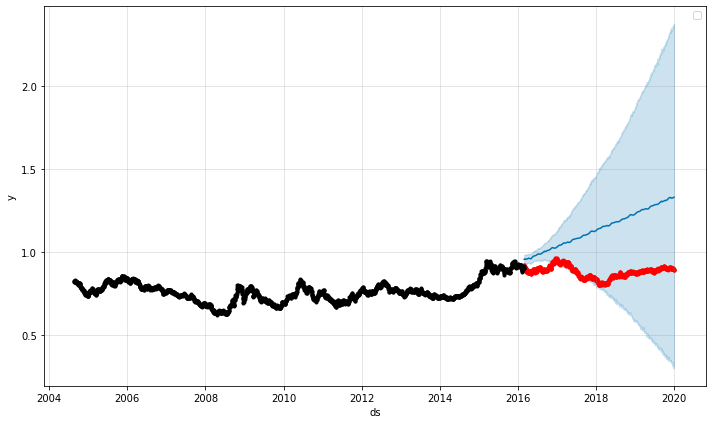

In [211]:
eur_summary_data, eur_classification, eur_confusion = build_prophet(data_eur,'EURUSD','eur_spread')

### NZD

In [212]:
data_nzd = data[['NZDUSD', 'YC/NZL5Y - Rate', 'YC/USA5Y - Rate']]
data_nzd[['YC/NZL5Y - Rate', 'YC/USA5Y - Rate']] = data_nzd[['YC/NZL5Y - Rate', 'YC/USA5Y - Rate']].shift()
data_nzd['Change in Spot'] = data_nzd['NZDUSD'].diff()
data_nzd['Direction'] = np.where(data_nzd['Change in Spot'] > 0, 1, 0)
data_nzd['nzd_spread'] = (data['YC/NZL5Y - Rate'])/(data['YC/USA5Y - Rate'])
data_nzd = data_nzd.dropna()
X_nzd, y_nzd = data_nzd[['YC/NZL5Y - Rate', 'YC/USA5Y - Rate']], data_nzd['Direction']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


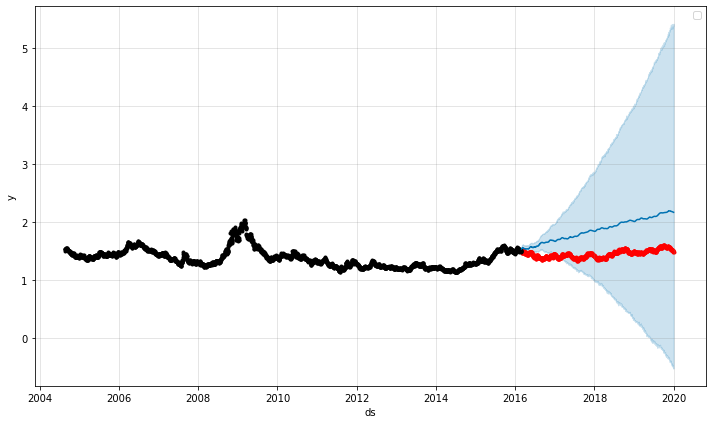

In [213]:
nzd_summary_data, nzd_classification, nzd_confusion = build_prophet(data_nzd,'NZDUSD','nzd_spread')

### JPY

In [216]:
data_jpy = data[['JPYUSD', 'YC/JPN5Y - Yield', 'YC/USA5Y - Rate']]
data_jpy[['YC/JPN5Y - Yield', 'YC/USA5Y - Rate']] = data_jpy[['YC/JPN5Y - Yield', 'YC/USA5Y - Rate']].shift()
data_jpy['Change in Spot'] = data_jpy['JPYUSD'].diff()
data_jpy['Direction'] = np.where(data_jpy['Change in Spot'] > 0, 1, 0)
data_jpy['jpy_spread'] = (data['YC/JPN5Y - Yield'])/(data['YC/USA5Y - Rate'])
data_jpy = data_jpy.dropna()
X_jpy, y_jpy = data_jpy[['YC/JPN5Y - Yield', 'YC/USA5Y - Rate']], data_jpy['Direction']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


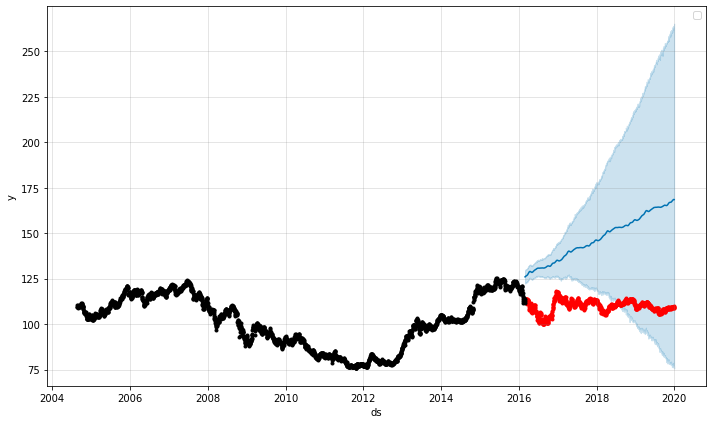

In [217]:
jpy_summary_data, jpy_classification, jpy_confusion = build_prophet(data_jpy,'JPYUSD','jpy_spread')

### Evaluation

In [218]:
pd.concat([eur_summary_data, nzd_summary_data, gbp_summary_data, cad_summary_data, jpy_summary_data], axis = 0)

,MAE,MSE,RMSE,MAPE,sMAPE,MASE
Test vs Pred - EURUSD,0.258769,0.081677,0.285792,0.218847,0.251254,75.486079
Test vs Pred - NZDUSD,0.413561,0.195947,0.442659,0.215704,0.244931,46.194350
Test vs Pred - GBPUSD,0.036116,0.002119,0.046036,0.049758,0.047973,14.066750
Test vs Pred - CADUSD,0.334661,0.136255,0.369127,0.196478,0.221989,69.385721
Test vs Pred - JPYUSD,37.517877,1563.905968,39.546251,0.249592,0.288312,81.546994


In [219]:
print(gbp_classification)
print(cad_classification)
print(eur_classification)
print(nzd_classification)
print(jpy_classification)

              precision    recall  f1-score   support

           0       0.59      0.54      0.57       499
           1       0.58      0.63      0.60       501

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000

              precision    recall  f1-score   support

           0       0.60      0.25      0.35       501
           1       0.52      0.84      0.64       499

    accuracy                           0.54      1000
   macro avg       0.56      0.54      0.50      1000
weighted avg       0.56      0.54      0.50      1000

              precision    recall  f1-score   support

           0       0.51      0.20      0.28       496
           1       0.51      0.81      0.62       504

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.45      1000
weighted avg       0.51      0.51      0.46      1000

              preci